<div class="alert alert-block alert-danger">
<h1>Bank Customer Churn</h1>
</div>

- Goal is to predict which customers are likely to leave the bank using customer data.

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Functions to be used](#1.0)<br>
    <ul>
        <li>Pyspark</li>
        <li>Visualizations</li>
        <li>Confusion matrix and metrics</li>
    </ul>
[Import Libraries](#2.0)<br>
[Initialize Spark and Load Data](#3.0)<br>
[Exploratory Data Analysis (EDA)](#4.0)<br>
    <ul>
        <li>[Analyze each feature](#4.1)</li>
    </ul>
[Machine Learning Algorithms and Results](#5.0)<br>
    <ul>
        <li>[String Indexer](#5.1)</li>
        <li>[Vector Assembler](#5.2)</li>
        <li>[Feature engineering](#5.3)</li>
        <li>[Correlation of the features](#5.4)</li>
        <li>[One Hot Encoding](#5.5)</li>
        <li>[Split Dataframe](#5.6)</li>
        <li>[Over Sampling](#5.7)</li>
        <li>[Building ML models](#5.8)</li>
            <ul>
                <li>Logistic Regression</li>
                <li>Decision Tree Classification</li>
                <li>Random Forest Classification</li>
                <li>Naive Bayes Classification</li>
                <li>Gradient-Boosted Tree Classification</li>
                <li>Linear Support Vector Machine</li>
            </ul>
        <li>[Model selection - final](#5.9)</li>
        <li>[Evaluation of the selected model](#5.10)</li>
            <ul>
                <li>ROC/AUC</li>
                <li>TPR/TNR - Threshold</li>
                <li>Precision(PPV)/NPV - Recall</li>
                <li>Accuracy - Threshold</li>
            </ul>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Functions to be used</h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pyspark
    </h4>
</div>

In [1]:
def count_null_columns(df):
    null_counts = df.select([count(when((col(c).isNull()), c)).alias(c) for c in df.columns])\
    .collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v == 0]
    df = df.drop(*to_drop)
    if len(df.columns) > 0:
        df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    else:
        print("There are no null values in the dataframe.")
        
    return df

In [2]:
from pyspark.sql.functions import sum, round

def percentCol(df, col):
    df = df.groupBy(col).count().orderBy("count", ascending=False)
    if df.count() > 10:
        df = df.limit(8)
        print("The first 8 items have been plotted.")
    df = df.withColumn('percentage (%)', 100*df['count'] / df.agg(sum("count")).collect()[0][0])
    df = df.select("*",round("percentage (%)", 2).alias('percentage (%)_')).drop('percentage (%)')
    df = df.withColumnRenamed('percentage (%)_', 'percentage (%)')
    df = df.na.fill('nan')
    df = df.toPandas().set_index(df.columns[0])
    return df

In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

def stringIndexer(df, inputCols, dropInput=False):
    outputCols = [f"{i}_si" for i in inputCols]

    for i in range(len(inputCols)):
        inputCol = inputCols[i]
        outputCol = outputCols[i]
        indexer = StringIndexer(inputCol=inputCol, outputCol=outputCol, handleInvalid="keep").fit(df)
        df = indexer.transform(df)\
           .withColumn(outputCol, when(col(outputCol) == len(indexer.labels), None).otherwise(col(outputCol)))
        if dropInput:
            df = df.drop(inputCol).withColumnRenamed(outputCol, inputCol)
        df = df.withColumn(inputCol, df[inputCol].cast(IntegerType()))
        
    return df

In [4]:
from pyspark.ml.feature import OneHotEncoder

def oneHotEncoder(df, inputCols, stringIndexer=False):
    if stringIndexer:
        for i in range(len(inputCols)):
            inputCol = inputCols[i]
            outputCol = f"{inputCol}_si"
            indexer = StringIndexer(inputCol=inputCol, outputCol=outputCol).fit(df)
            data = indexer.transform(df).withColumn(outputCol, 
                                                    when(col(outputCol) == len(indexer.labels), None)
                                                    .otherwise(col(outputCol))).drop(inputCol)
            ohe = OneHotEncoder(inputCol=outputCol, outputCol=f"{inputCol}_ohe").fit(data)
            data = ohe.transform(data).drop(outputCol)
        return data
    else:
        for i in range(len(inputCols)):
            inputCol = inputCols[i]
            ohe = OneHotEncoder(inputCol=inputCol, outputCol=f"{inputCol}_ohe").fit(df)
            df = ohe.transform(df).drop(inputCol)
        return df

In [5]:
from pyspark.ml.feature import VectorAssembler

def vectorAssembler(df, inputCols, dependentCol):
    va = VectorAssembler(inputCols=inputCols, outputCol='features')
    output = va.transform(df)
    df_final = output.select('features', dependentCol)
    
    return df_final

In [6]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
import math

def BuildMLModel(model, df_train, df_test, paramGrid, threshold=0.5, modelName=None):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                  metricName="accuracy")
    cv = CrossValidator(estimator=model, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    cv_trained = cv.fit(df_train)
    cv_pred = cv_trained.transform(df_test)

    if modelName=="LinearSVC":
        y_prob = np.array([(np.exp(np.array([i[0][0], -i[0][0]]))
                                  /(1+np.exp(np.array([i[0][0], -i[0][0]]))))[1] for i in cv_pred
                                 .select("rawPrediction").collect()])
        y = np.array([i[0] for i in cv_pred.select("label").collect()])
    else:
        y_prob = np.array([i[0][1] for i in cv_pred.select("probability").collect()])
        y = np.array([i[0] for i in cv_pred.select("label").collect()])
    y_pred = (y_prob  >= threshold).astype('int')

    model_cm = confusion_matrix(y, y_pred)
    model_cm_norm = confusion_matrix(y, y_pred, normalize='true')

    model_cm_metrics = confusion_matrix_func(model_cm, model_cm_norm)
    
    return model_cm_metrics, cv_pred

In [7]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.MinMaxScaler.html
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

def minMaxScaler(df, inputCol):
   # VectorAssembler Transformation - Converting column to vector type
    vec_assem = VectorAssembler(inputCols=[inputCol], outputCol=inputCol+"_vect")
    vec_trans = vec_assem.transform(df)
    
    # MinMaxScaler
    mmScaler = MinMaxScaler(inputCol=inputCol+"_vect", outputCol=inputCol+"_mm")
    mmScaler_model = mmScaler.fit(vec_trans)
    df_mm = mmScaler_model.transform(vec_trans).drop(inputCol, inputCol+"_vect")
    
    return df_mm

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [8]:
from pyspark.sql.functions import col

# plot a stacked bar chart to show how a feature is categorized using the another feature
def stacked_bar_chart(df_target, target_col, figsize=(8,5)):
    
    df = df_target.groupBy(target_col, "label").count().orderBy("count", ascending=False)\
    .groupBy(target_col).pivot("label").sum("count").orderBy([target_col], ascending=True).fillna(0)\
    .withColumn('sum_each', col("0") + col("1")).orderBy("sum_each", ascending=False)\
    .select([target_col] + ["0", "1"]).toPandas().set_index(target_col)
    
    if len(df) > 10:
        df = df.iloc[:8, :]
        print("The first 8 items have been plotted.")
    
    print(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35
    
    colors = []
    for column in df.columns:
        if column == '0':
            colors.append('royalblue')
        elif column == '1':
            colors.append('mediumvioletred')
    
    x = [str(i) for i in df.index]
    y = 0
    for i, col_group in enumerate(df.columns):
        try:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors[i], label=df.columns[i], zorder=3)
        except:
            ax.bar(x, df[col_group].values, width, bottom=y, color=colors(i), label=df.columns[i], zorder=3)
        y += df[col_group].values
    
    ax.set_xticklabels(x, rotation = 45)
    
    ax.set_xlabel(df.index.name)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(axis='y', zorder=0, lw=0.2)
        
    plt.show()

In [9]:
def histogram(df, target_col, figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

    age_vals = [i[0] for i in df.select(target_col).na.drop().collect()]

    sigma = df.agg({target_col:'std'}).collect()[0][0]
    mean = df.agg({target_col:'mean'}).collect()[0][0]
    median = np.median(age_vals)
    mode = stats.mode(age_vals)[0][0]   

    x = mean + sigma * np.random.randn(1000)

    # fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    n, bins, patches = ax.hist(age_vals, 20, density=True, color='lightgreen', 
                                           stacked=True, alpha=0.75)

    # add mean, median and mode lines
    ax.axvline(mean, 0, 1, color='red', label='mean: {:.2f}'.format(mean))
    ax.axvline(median, 0, 1, color='blue', label='median: {:.2f}'.format(median))
    ax.axvline(mode, 0, 1, color='green', label='mode: {:.2f}'.format(mode))

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--', color ='black')

    ax.grid(True)
    ax.set_ylabel('Probability')
    ax.set_title(f'{target_col} (sigma={roundF(sigma, 2)})')
    ax.legend()
    fig.tight_layout()
    fig.show()

In [10]:
def create_heatmap(hm, cols, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    
    
    ax.set_xticks(np.arange(len(cols)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(cols)+1)-.5, minor=True)
    
    
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            hm_val = roundF(hm[i][j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

In [11]:
def autopct(pct_max, pct, allvals):
    if pct<pct_max:
        return ""
    else:
        # ATTENSION: roundF and sumF is used because of the Pyspark
        absolute = int(roundF(pct/100.*sumF(allvals), 0))
        return "{p:.1f}% \n({val})".format(p=pct, val=absolute)

def pie_chart(df, explode=None, title=None, pct_max=5, legend_pos=(0.8, 0, 0.4, 1), 
              p_theta_max=15, p_theta_min=2):
#     df = df.toPandas().set_index(df.columns[0])
#     df.index.name = None
    items = df.index
    values = df.iloc[:, 0]
    percent = df.iloc[:, 1]
    
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    #################################################################
    textprops = dict(horizontalalignment="center", verticalalignment="center", rotation=0, 
                     rotation_mode="anchor", size=12, weight= "bold", color="white")
    wedgeprops=dict(edgecolor="black", linewidth=1)
    labels = [f"{i} ({j} - {k:1.1f}%)" for i,j,k in zip(items, values, percent)]
    #################################################################
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: autopct(pct_max, pct, values), 
                                      textprops=textprops, radius=1, startangle=0, counterclock=True, 
                                      pctdistance = 0.6, wedgeprops=wedgeprops, explode=explode)
    #################################################################
    #---------------------------------------------------------------#
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center", ha="center")

    values_2 = [f"{i:1.1f}% ({j})" for i,j in zip(percent, values)]

    for i, p in enumerate(wedges):
        if (p.theta2 - p.theta1 < p_theta_max) & (p.theta2 - p.theta1 > p_theta_min):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.annotate(values_2[i], xy=(x, y), xytext=(1.6*np.sign(x), 1.5*y),
                        horizontalalignment=horizontalalignment, **kw)
    #---------------------------------------------------------------#
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size=16, weight="bold")

    plt.legend(labels=labels, fontsize=12, bbox_to_anchor=legend_pos)
        
    plt.show()

In [12]:
def balanceOrInbalance(df_label):
    col = df_Exited.index.name
    uniqs = [str(i) for i in df_label.index]
    vals = [i for i in df_label["count"].values]
    
    fig, ax = plt.subplots(figsize = (12, 2))
    # Horizontal bar chart
    ax.barh(uniqs, vals, align='center', color=['red', 'green'])
    ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
    ax.text(vals[1]-vals[1]*0.2, 1, vals[1], ha='center', va='center', color='w', size=20)
    ax.set_ylabel(col)
    ax.set_title('Balance situation in the dependent feature')

    plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [13]:
def TP_FP_TN_FN_func(cm, dataframe):
    
    TN, FP, FN, TP = cm.ravel()

    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = roundF(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = roundF(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = roundF((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = roundF((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = roundF(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = roundF(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = roundF(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = roundF(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = roundF((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = roundF(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = roundF(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = roundF(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = roundF(FN / (FN + TP), 2)
    

    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 'Precision', 
                  'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    df_cm_metrics = pd.DataFrame([[TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR]], 
                                 columns=metrics_cols, index=[""])
    
    return df_cm_metrics

def confusion_matrix_func(cm, cm_norm, threshold=0.5):
    cm = cm.astype(int)

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    im_norm = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Reds', aspect='auto')
    
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    axes[1].set_xticks(np.arange(len(cm_norm.tolist())))
    axes[1].set_yticks(np.arange(len(cm_norm.tolist())))

    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
            
    for i in range(len(cm_norm.tolist())):
        for j in range(len(cm_norm.tolist())):
            text = axes[1].text(j, i, f"{roundF(cm_norm.tolist()[i][j]*100, 1)} %",
                           ha="center", va="center", size=16,
                           color="white" if cm_norm[i, j] > 0.5 else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Predicted value', size=16)
    axes[0].set_ylabel('Actual value', size=16)
    axes[0].set_title("Confusion matrix", fontsize=16, color="blue")

    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Predicted value', size=16)
    axes[1].set_ylabel('Actual value', size=16)
    axes[1].set_title("Normalized confusion matrix", fontsize=16, color="blue")
    
    fig.tight_layout()
    fig.show()
    
#     get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Test')
    
    return df_cm_metrics

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Import Libraries</h2>
</div>

In [14]:
import warnings
warnings.filterwarnings('ignore')

import math, operator
from scipy import stats
import numpy as np 
import pandas as pd
# display all of the columns
pd.set_option('display.max_columns', None)

from matplotlib import pyplot as plt
%matplotlib inline

import findspark
findspark.init("/Users/onurkaraguler/Spark/spark-3.2.0-bin-hadoop3.2") 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

# for round, sum method
import pyspark.sql.functions as F
import builtins
roundF = getattr(builtins, "round")
sumF = getattr(builtins, "sum")
absF = getattr(builtins, "abs")

<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Initialize Spark and Load Data</h2>
</div>

<div class="alert alert-block alert-warning">
        Initialize Spark
</div>

In [15]:
spark=SparkSession.builder.appName('Dataframe').getOrCreate()
# spark

22/04/08 01:08:36 WARN Utils: Your hostname, Onur-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.21 instead (on interface en0)
22/04/08 01:08:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/08 01:08:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<div class="alert alert-block alert-warning">
        Load the data
</div>

In [16]:
# read the dataset
# df = spark.read.option('header','true').csv('../all_dfs/adult.csv', inferSchema=True)
df = spark.read.option('header','true').csv('Churn_Modelling.csv', inferSchema=True)
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<strong>Content</strong><br>
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.<br>
- CustomerId: Unique Ids for bank customer identification
- Surname: Customer's last name
- CreditScore: Credit score of the customer
- Geography: The country from which the customer belongs
- Gender: Male or Female
- Age: Age of the customer
- Tenure: Number of years for which the customer has been with the bank
- Balance: Bank balance of the customer
- NumOfProducts: Number of bank products the customer is utilising
- HasCrCard: Binary Flag for whether the customer holds a credit card with the bank or not
- IsActiveMember: Binary Flag for whether the customer is an active member with the bank or not
- EstimatedSalary: Estimated salary of the customer in Dollars
- Exited: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained

In [17]:
f"Total transactions: {df.count()}"

'Total transactions: 10000'

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Exploratory Data Analysis (EDA)</h2>
</div>

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Check missing values
</div>

In [18]:
count_null_columns(df)

There are no null values in the dataframe.


DataFrame[]

<div class="alert alert-block alert-success">
    <h4>
        Exited
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Distribution of total transactions
</div>

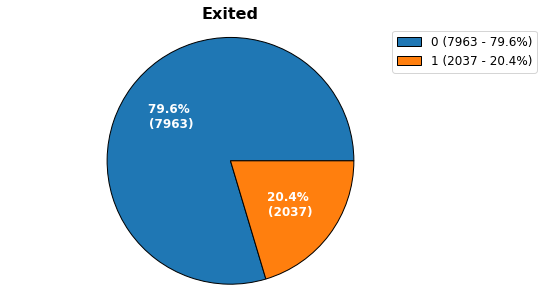

In [19]:
df_Exited = percentCol(df, 'Exited')
pie_chart(df_Exited, title='Exited')

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

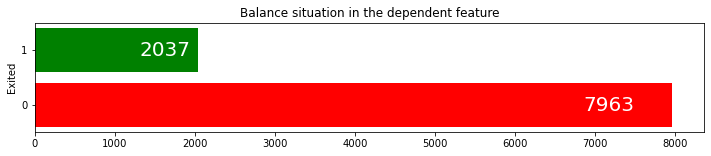

In [20]:
balanceOrInbalance(df_Exited)

- The difference between 0 and 1 values in the dependent feature is not same. So the dataset is in imbalance.

<div class="alert alert-block alert-warning">
        Remane the dependent feature name as "label"
</div>

In [21]:
df = df.withColumn('label', df['Exited']).drop("Exited")
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,label
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<div class="alert alert-block alert-success">
    <h4>
        Geography
    </h4>
</div>

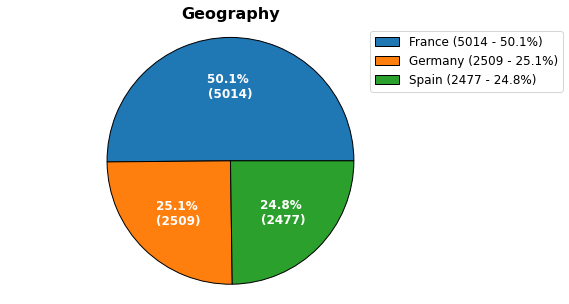

In [22]:
df_Geography = percentCol(df, 'Geography')
pie_chart(df_Geography, title='Geography')

              0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413


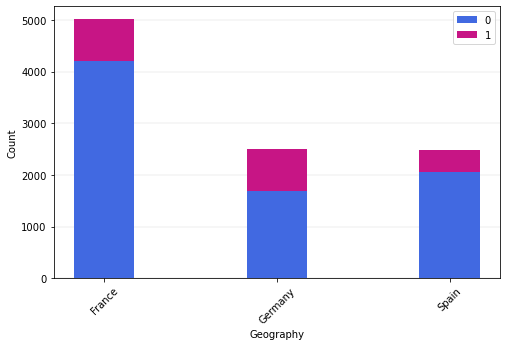

In [23]:
stacked_bar_chart(df, 'Geography')

In [24]:
# France
print('{:.1%} of France customers closed their accounts.'.format(810/(4204+810)))
print('=====')
# Germany
print('{:.1%} of German customers closed their accounts.'.format(814/(1695+814)))
print('=====')
# Spain
print('{:.1%} of Spain customers closed their accounts.'.format(413/(2064+413)))

16.2% of France customers closed their accounts.
=====
32.4% of German customers closed their accounts.
=====
16.7% of Spain customers closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        Gender
    </h4>
</div>

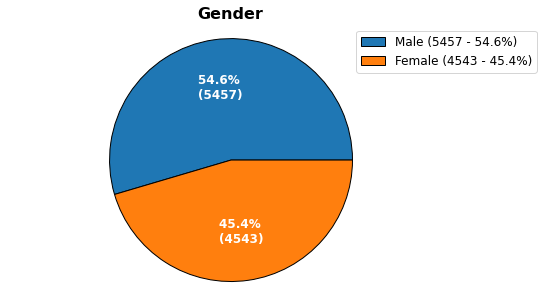

In [25]:
df_Gender = percentCol(df, 'Gender')
pie_chart(df_Gender, title='Gender')

           0     1
Gender            
Male    4559   898
Female  3404  1139


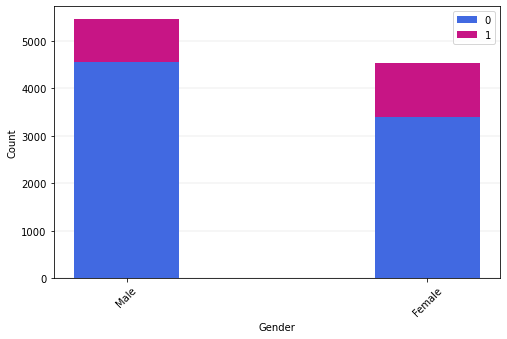

In [26]:
stacked_bar_chart(df, 'Gender')

In [27]:
print('{:.1%} of Female customers closed their accounts.'.format(1139/(3404+1139)))
print('=====')
print('{:.1%} of Male customers closed their accounts.'.format(898/(4559+898)))

25.1% of Female customers closed their accounts.
=====
16.5% of Male customers closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        NumOfProducts
    </h4>
</div>

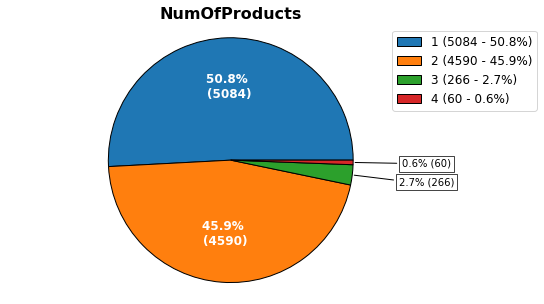

In [28]:
df_NumOfProducts = percentCol(df, 'NumOfProducts')
pie_chart(df_NumOfProducts, title='NumOfProducts')

                  0     1
NumOfProducts            
1              3675  1409
2              4242   348
3                46   220
4                 0    60


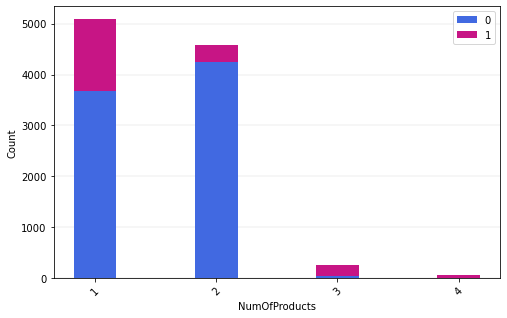

In [29]:
stacked_bar_chart(df, 'NumOfProducts')

In [30]:
print('{:.1%} of customers use 1 of bank products closed their accounts.'.format(1409/(3675+1409)))
print('=====')
print('{:.1%} of customers use 2 of bank products closed their accounts.'.format(348/(4242+348)))
print('=====')
print('{:.1%} of customers use 3 of bank products closed their accounts.'.format(220/(46+220)))
print('=====')
print('{:.1%} of customers use 4 of bank products closed their accounts.'.format(60/(0+60)))

27.7% of customers use 1 of bank products closed their accounts.
=====
7.6% of customers use 2 of bank products closed their accounts.
=====
82.7% of customers use 3 of bank products closed their accounts.
=====
100.0% of customers use 4 of bank products closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        HasCrCard
    </h4>
</div>

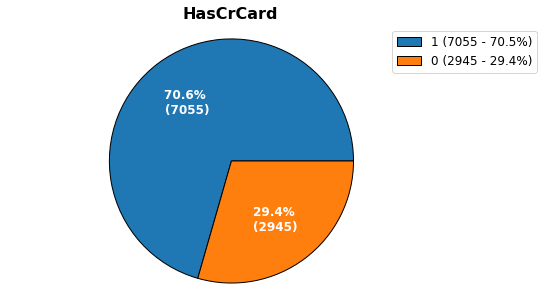

In [31]:
df_HasCrCard = percentCol(df, 'HasCrCard')
pie_chart(df_HasCrCard, title='HasCrCard')

              0     1
HasCrCard            
1          5631  1424
0          2332   613


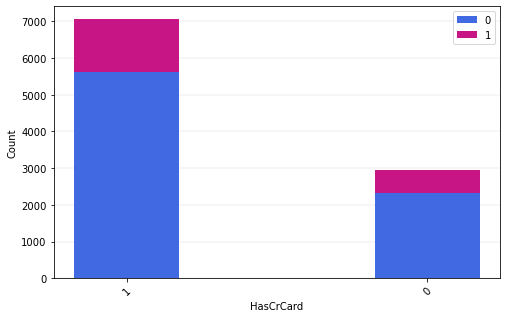

In [32]:
stacked_bar_chart(df, 'HasCrCard')

In [33]:
print('{:.1%} of customers does not have a credit card closed their accounts.'.format(613/(2332+613)))
print('=====')
print('{:.1%} of customers have a credit card closed their accounts.'.format(1424/(5631+1424)))

20.8% of customers does not have a credit card closed their accounts.
=====
20.2% of customers have a credit card closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        IsActiveMember
    </h4>
</div>

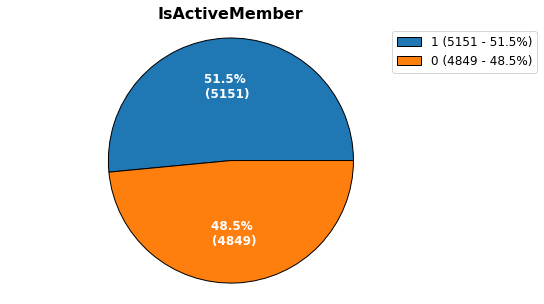

In [34]:
df_IsActiveMember = percentCol(df, 'IsActiveMember')
pie_chart(df_IsActiveMember, title='IsActiveMember')

                   0     1
IsActiveMember            
1               4416   735
0               3547  1302


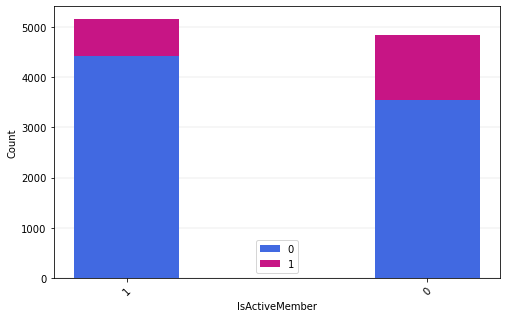

In [35]:
stacked_bar_chart(df, 'IsActiveMember')

In [36]:
print('{:.1%} of customers who are not active their accounts.'.format(1302/(3547+1302)))
print('=====')
print('{:.1%} of customers who are active closed their accounts.'.format(735/(4416+735)))

26.9% of customers who are not active their accounts.
=====
14.3% of customers who are active closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        Age
    </h4>
</div>

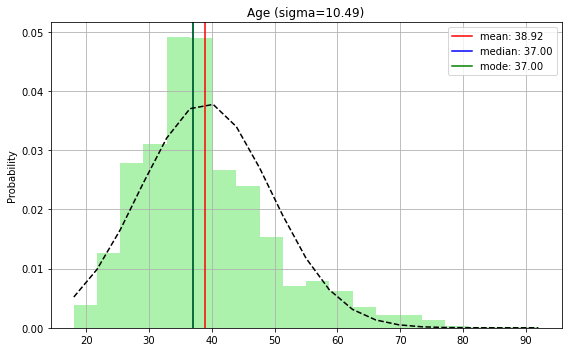

In [37]:
histogram(df, "Age")

In [38]:
age_min = df.agg({"Age": "min"}).collect()[0][0]
age_max = df.agg({"Age": "max"}).collect()[0][0]
print(f"min. age: {age_min}, \nmax. Age: {age_max}")

min. age: 18, 
max. Age: 92


In [39]:
# Categorize the 'Age' column with the labels and bins and create a new column in the df dataframe
from pyspark.ml.feature import Bucketizer

bins = [age_min-1,21,31,41,51,61,71, age_max+1]
bucketizer = Bucketizer(splits=bins, inputCol="Age", outputCol="AgeGrb")
df = bucketizer.setHandleInvalid("keep").transform(df)

In [40]:
labels = {None:None, 0.0:"0-20", 1.0: "21-30", 2.0:"31-40", 3.0: "41-50", 4.0: "51-60", 5.0: "61-70", 
          6.0: "71+"}
udf_foo = udf(lambda x: labels[x], StringType())
df = df.withColumn("AgeGrb", udf_foo("AgeGrb")).drop("Age")

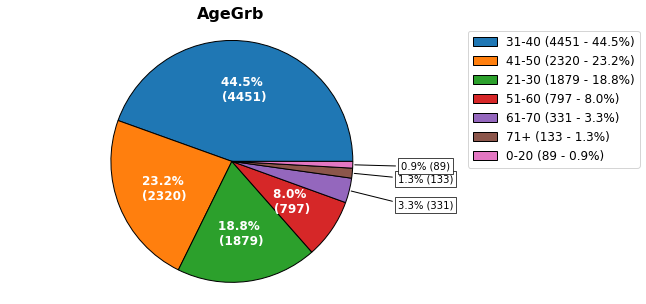

In [41]:
df_ageGrb = percentCol(df.na.fill('nan', subset=["AgeGrb"]), 'AgeGrb')
pie_chart(df_ageGrb, title='AgeGrb', legend_pos=(1.03, 0, 0.4, 1))

<div class="alert alert-block alert-success">
    <h4>
        Balance
    </h4>
</div>

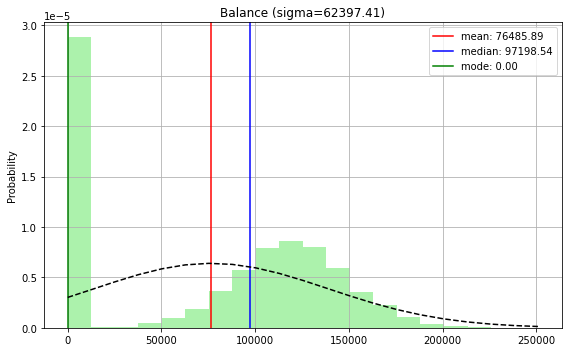

In [42]:
histogram(df, "Balance")

In [43]:
balance_min = df.agg({"Balance": "min"}).collect()[0][0]
balance_max = df.agg({"Balance": "max"}).collect()[0][0]
print(f"min. balance: {balance_min}, \nmax. Balance: {balance_max}")

min. balance: 0.0, 
max. Balance: 250898.09


<div class="alert alert-block alert-warning">
        Min-Max normalization
</div>

In [44]:
df = minMaxScaler(df, "Balance")
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,label,AgeGrb,Balance_mm
0,1,15634602,Hargrave,619,France,Female,2,1,1,1,101348.88,1,41-50,[0.0]
1,2,15647311,Hill,608,Spain,Female,1,1,0,1,112542.58,0,41-50,[0.334031478677259]
2,3,15619304,Onio,502,France,Female,8,3,1,0,113931.57,1,41-50,[0.6363571759354565]
3,4,15701354,Boni,699,France,Female,1,2,0,0,93826.63,0,31-40,[0.0]
4,5,15737888,Mitchell,850,Spain,Female,2,1,1,1,79084.10,0,41-50,[0.5002462155052676]


<div class="alert alert-block alert-success">
    <h4>
        EstimatedSalary
    </h4>
</div>

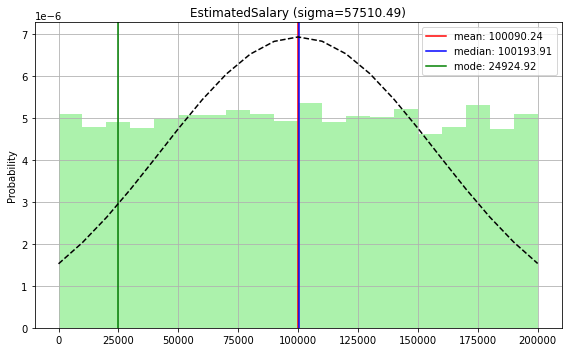

In [45]:
histogram(df, "EstimatedSalary")

In [46]:
estimatedSalary_min = df.agg({"EstimatedSalary": "min"}).collect()[0][0]
estimatedSalary_max = df.agg({"EstimatedSalary": "max"}).collect()[0][0]
print(f"min. Estimated Salary: {estimatedSalary_min}, \nmax. Estimated Salary: {estimatedSalary_max}")

min. Estimated Salary: 11.58, 
max. Estimated Salary: 199992.48


<div class="alert alert-block alert-warning">
        Min-Max normalization
</div>

In [47]:
df = minMaxScaler(df, "EstimatedSalary")
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,label,AgeGrb,Balance_mm,EstimatedSalary_mm
0,1,15634602,Hargrave,619,France,Female,2,1,1,1,1,41-50,[0.0],[0.5067348931822989]
1,2,15647311,Hill,608,Spain,Female,1,1,0,1,0,41-50,[0.334031478677259],[0.5627087386845443]
2,3,15619304,Onio,502,France,Female,8,3,1,0,1,41-50,[0.6363571759354565],[0.5696543519906151]
3,4,15701354,Boni,699,France,Female,1,2,0,0,0,31-40,[0.0],[0.4691200509648671]
4,5,15737888,Mitchell,850,Spain,Female,2,1,1,1,0,41-50,[0.5002462155052676],[0.3954003607344501]


<div class="alert alert-block alert-success">
    <h4>
        CreditScore
    </h4>
</div>

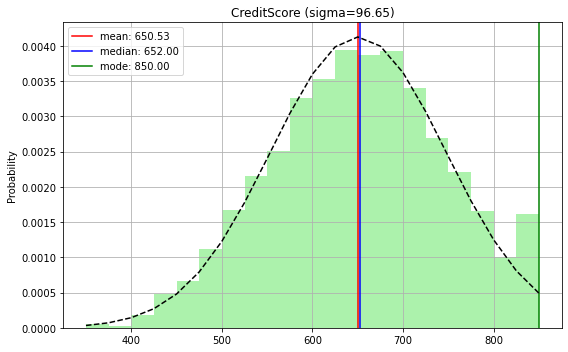

In [48]:
histogram(df, "CreditScore")

In [49]:
creditScore_min = df.agg({"CreditScore": "min"}).collect()[0][0]
creditScore_max = df.agg({"CreditScore": "max"}).collect()[0][0]
print(f"min. Credit Score: {creditScore_min}, \nmax. Credit Score: {creditScore_max}")

min. Credit Score: 350, 
max. Credit Score: 850


<div class="alert alert-block alert-warning">
        Min-Max normalization
</div>

In [50]:
df = minMaxScaler(df, "CreditScore")
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,CustomerId,Surname,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,label,AgeGrb,Balance_mm,EstimatedSalary_mm,CreditScore_mm
0,1,15634602,Hargrave,France,Female,2,1,1,1,1,41-50,[0.0],[0.5067348931822989],[0.538]
1,2,15647311,Hill,Spain,Female,1,1,0,1,0,41-50,[0.334031478677259],[0.5627087386845443],[0.516]
2,3,15619304,Onio,France,Female,8,3,1,0,1,41-50,[0.6363571759354565],[0.5696543519906151],[0.304]
3,4,15701354,Boni,France,Female,1,2,0,0,0,31-40,[0.0],[0.4691200509648671],[0.6980000000000001]
4,5,15737888,Mitchell,Spain,Female,2,1,1,1,0,41-50,[0.5002462155052676],[0.3954003607344501],[1.0]


<div class="alert alert-block alert-success">
    <h4>
        Tenure
    </h4>
</div>

The first 8 items have been plotted.


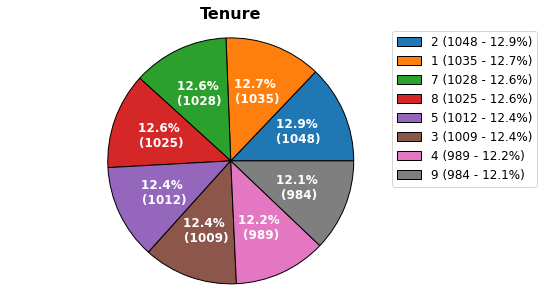

In [51]:
df_Tenure = percentCol(df, 'Tenure')
pie_chart(df_Tenure, title='Tenure')

The first 8 items have been plotted.
          0    1
Tenure          
2       847  201
1       803  232
7       851  177
8       828  197
5       803  209
3       796  213
4       786  203
9       771  213


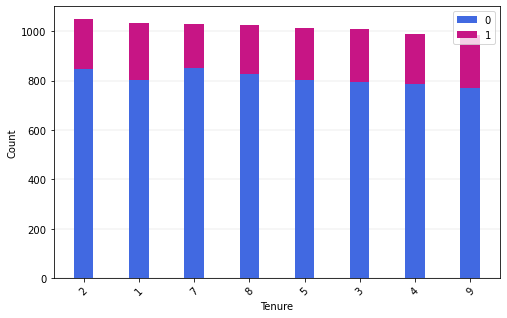

In [52]:
stacked_bar_chart(df, 'Tenure')

<div class="alert alert-block alert-success">
    <h4>
        CustomerId
    </h4>
</div>

In [53]:
customerId_category = []
for i in df.select('CustomerId').collect():
    customerId_category.append(str(i[0])[:3])
df = df.repartition(1).withColumn(
    'customerId_category', 
    udf(lambda id: customerId_category[id])(monotonically_increasing_id()))
df = df.drop('CustomerId')
pd.DataFrame(df.take(5), columns=df.columns)

,RowNumber,Surname,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,label,AgeGrb,Balance_mm,EstimatedSalary_mm,CreditScore_mm,customerId_category
0,1,Hargrave,France,Female,2,1,1,1,1,41-50,[0.0],[0.5067348931822989],[0.538],156
1,2,Hill,Spain,Female,1,1,0,1,0,41-50,[0.334031478677259],[0.5627087386845443],[0.516],156
2,3,Onio,France,Female,8,3,1,0,1,41-50,[0.6363571759354565],[0.5696543519906151],[0.304],156
3,4,Boni,France,Female,1,2,0,0,0,31-40,[0.0],[0.4691200509648671],[0.6980000000000001],157
4,5,Mitchell,Spain,Female,2,1,1,1,0,41-50,[0.5002462155052676],[0.3954003607344501],[1.0],157


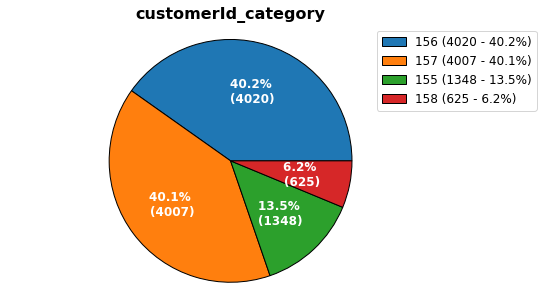

In [54]:
df_customerId_category = percentCol(df, 'customerId_category')
pie_chart(df_customerId_category, title='customerId_category')

                        0    1
customerId_category           
156                  3211  809
157                  3204  803
155                  1055  293
158                   493  132


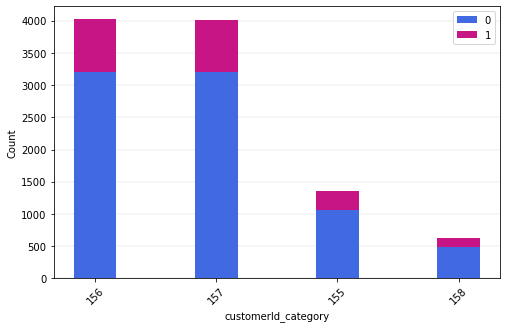

In [55]:
stacked_bar_chart(df, 'customerId_category')

In [56]:
print('{:.1%} of customers with 155 ID closed their accounts.'.format(293/(1055+293)))
print('=====')
print('{:.1%} of customers with 156 ID closed their accounts.'.format(809/(3211+809)))
print('=====')
print('{:.1%} of customers with 157 ID closed their accounts.'.format(803/(3211+803)))
print('=====')
print('{:.1%} of customers with 158 ID closed their accounts.'.format(132/(493+132)))

21.7% of customers with 155 ID closed their accounts.
=====
20.1% of customers with 156 ID closed their accounts.
=====
20.0% of customers with 157 ID closed their accounts.
=====
21.1% of customers with 158 ID closed their accounts.


<div class="alert alert-block alert-success">
    <h4>
        Drop features
    </h4>
</div>

In [57]:
df = df.drop('RowNumber', 'Surname')

<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        String Indexer
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Move the label column to end and encodes it
</div>

In [58]:
labelCol = ["label"]
cols = [i for i in df.columns if not i in labelCol]
new_order = cols + labelCol
df = df.select(new_order)

<div class="alert alert-block alert-warning">
        Get Categorical Features
</div>

In [59]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if not item[1].startswith('string')]
print(f"Categorical features:{cat_cols}")
print('='*50)
print(f"Numerical features:{num_cols}")

Categorical features:['Geography', 'Gender', 'AgeGrb', 'customerId_category']
Numerical features:['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance_mm', 'EstimatedSalary_mm', 'CreditScore_mm', 'label']


<div class="alert alert-block alert-warning">
        String Indexer
</div>

In [60]:
df_enc = stringIndexer(df, cat_cols, dropInput=True)
cols = [i for i in df_enc.columns if not i in labelCol]
new_order = cols + labelCol
df_enc = df_enc.select(new_order)

In [61]:
pd.DataFrame(df_enc.take(3), columns=df_enc.columns)

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Balance_mm,EstimatedSalary_mm,CreditScore_mm,Geography,Gender,AgeGrb,customerId_category,label
0,2,1,1,1,[0.0],[0.5067348931822989],[0.538],0,1,1,0,1
1,1,1,0,1,[0.334031478677259],[0.5627087386845443],[0.516],2,1,1,0,0
2,8,3,1,0,[0.6363571759354565],[0.5696543519906151],[0.304],0,1,1,0,1


<a id='5.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Vector Assembler
   </h3>
</div>

In [62]:
cols_for_vec = df_enc.columns
cols_for_vec.remove("label")
vec_assem = VectorAssembler(inputCols=cols_for_vec, outputCol="features")
vec_trans = vec_assem.transform(df_enc)
vec_trans = vec_trans.select("features", "label")

<a id='5.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature engineering
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Check categorical Features
    </h4>
</div>

In [63]:
cat_cols = [item[0] for item in df_enc.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df_enc.dtypes if not item[1].startswith('string')]
print(f"Categorical features:{cat_cols}")
print('='*50)
print(f"Numerical features:{num_cols}")

Categorical features:[]
Numerical features:['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance_mm', 'EstimatedSalary_mm', 'CreditScore_mm', 'Geography', 'Gender', 'AgeGrb', 'customerId_category', 'label']


- There is no categorical columns in the dataframe

<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value 

In [64]:
from pyspark.ml.feature import VarianceThresholdSelector
fvts = VarianceThresholdSelector(varianceThreshold=0.01, featuresCol="features", outputCol="selectedFeatures")
fvts_model = fvts.fit(vec_trans)
vec_trans = fvts_model.transform(vec_trans).drop("features")\
.withColumnRenamed("selectedFeatures", "features").select("features", "label")

In [65]:
fvts_model.selectedFeatures

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [66]:
print(cols_for_vec)

['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance_mm', 'EstimatedSalary_mm', 'CreditScore_mm', 'Geography', 'Gender', 'AgeGrb', 'customerId_category']


<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" style="height:250px">

Pearson correlation coefficient
- a measure of linear correlation between features
- the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation
- the result always has a value between −1 and 1

In [67]:
from pyspark.ml.stat import Correlation

def highly_correlated_features(df, threshold):
    # correlation will be in Dense Matrix
    matrix = Correlation.corr(df, 'features')
    corr_matrix = pd.DataFrame(matrix.collect()[0][matrix.columns[0]].toArray(), 
                               columns=cols_for_vec, index=cols_for_vec)

    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if absF(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = absF(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(vec_trans.select("features"), 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

22/04/08 01:09:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/04/08 01:09:27 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


,Feature_1,Feature_2,Corr_value


<div class="alert alert-block alert-warning">
        Feature importance based on RandomForestClassifier
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [68]:
from pyspark.ml.classification import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list
        
        df_for_vec = df_enc.select(correlated_features_list + ["label"])
        df_vec = vectorAssembler(df_for_vec, correlated_features_list, "label")

        rf=RandomForestClassifier(labelCol="label")
        rf_trained = rf.fit(df_vec)
        feature_imp_array = rf_trained.featureImportances.toArray()
    
        feat_imp_list = []
        for feature, importance in zip(correlated_features_list, feature_imp_array):
            feat_imp_list.append((feature, importance))
        df_feat_imp = pd.DataFrame(feat_imp_list)
        df_feat_imp.columns = ['Feature', 'Importance']
        df_feat_imp.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_feat_imp['Feature'][1:].values)
    
print(dropped_feature_list)  

[]


In [69]:
# df_enc = df_enc.drop(dropped_feature_list)

<a id='5.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

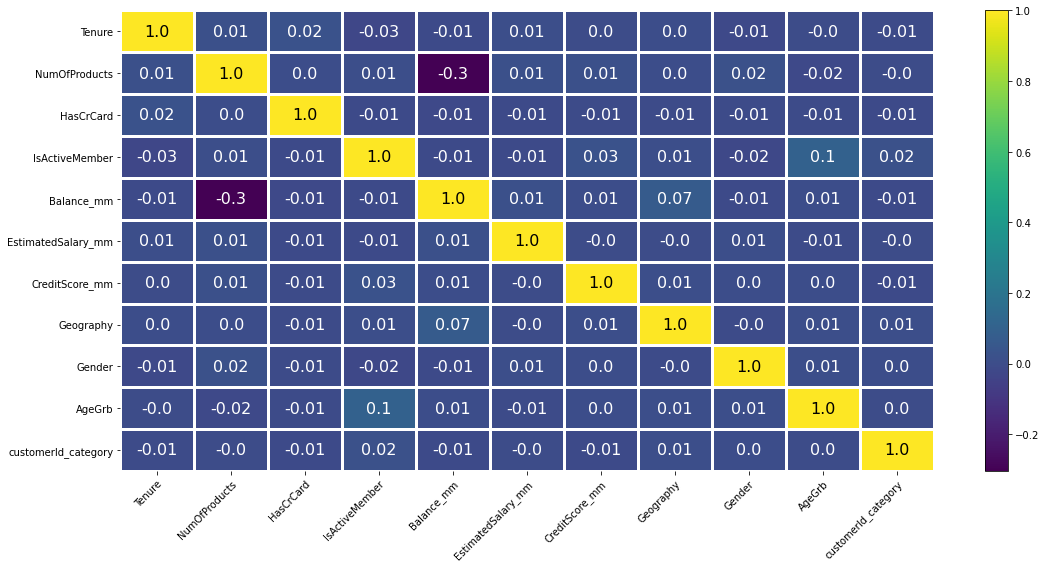

In [70]:
from pyspark.ml.stat import Correlation

# correlation will be in Dense Matrix
matrix = Correlation.corr(vec_trans, 'features').collect()[0][0]

# convert Dense Matrix into DataFrame
corr_mat = matrix.toArray().tolist()
create_heatmap(corr_mat, cols_for_vec, figsize=(16, 8))

<div class="alert alert-block alert-warning">
        ["CreditScore", "HasCrCard", "EstimatedSalary", "Gender", "customerId_category"] have no correlation with other columns
</div>

In [71]:
# df_enc = df_enc.drop("CreditScore", "HasCrCard", "EstimatedSalary", "Gender", "customerId_category")

In [72]:
# pd.DataFrame(df_enc.take(3), columns=df_enc.columns)

<a id='5.5'></a>
<div class="alert alert-block alert-info">
   <h3>
        One Hot Encoding
   </h3>
</div>

In [73]:
cat_cols = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography', 'Gender', 'AgeGrb', 
            'customerId_category']
df_ohe = oneHotEncoder(df_enc, cat_cols, stringIndexer=False)

<div class="alert alert-block alert-warning">
        Move the label column to end and encodes it
</div>

In [74]:
cols = [i for i in df_ohe.columns if i!="label"]
new_order = cols + ["label"]
df_ohe = df_ohe.select(new_order)

In [75]:
pd.DataFrame(df_ohe.take(3), columns=df_enc.columns)

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Balance_mm,EstimatedSalary_mm,CreditScore_mm,Geography,Gender,AgeGrb,customerId_category,label
0,[0.0],[0.5067348931822989],[0.538],"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)",(0.0),(0.0),"(1.0, 0.0)",(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",1
1,[0.334031478677259],[0.5627087386845443],[0.516],"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0)",(1.0),(0.0),"(0.0, 0.0)",(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",0
2,[0.6363571759354565],[0.5696543519906151],[0.304],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 0.0, 1.0)",(0.0),(1.0),"(1.0, 0.0)",(0.0),"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)",1


<a id='5.6'></a>
<div class="alert alert-block alert-info">
   <h3>
        Split Dataframe
   </h3>
</div>

In [76]:
df_train, df_test = df_ohe.randomSplit([0.70,0.30])

<a id='5.7'></a>
<div class="alert alert-block alert-info">
   <h3>
        Over-sampling
   </h3>
</div>

In [77]:
df_train_0 = df_train.where(col("label") == 0)
df_train_1 = df_train.where(col("label") == 1)

In [78]:
ratio = df_train_0.count() / df_train_1.count()
df_train_1_over = df_train_1.sample(withReplacement=True, fraction=ratio, seed=1)
df_train_over = df_train_0.unionAll(df_train_1_over)

In [79]:
df_train.count()

6963

In [80]:
df_train_over.count()

10982

In [83]:
df_train_over

DataFrame[Balance_mm: vector, EstimatedSalary_mm: vector, CreditScore_mm: vector, Tenure_ohe: vector, NumOfProducts_ohe: vector, HasCrCard_ohe: vector, IsActiveMember_ohe: vector, Geography_ohe: vector, Gender_ohe: vector, AgeGrb_ohe: vector, customerId_category_ohe: vector, label: int]

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

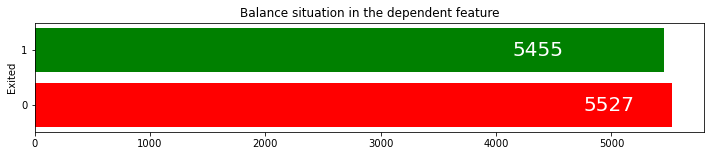

In [86]:
balanceOrInbalance(percentCol(df_train_over, 'label'))

- The difference between 0 and 1 values in the dependent feature is almost same. So the dataset is in balance.

<a id='5.8'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Vector Assembler
</div>

In [87]:
inputCols = [i for i in df_train_over.columns if i!="label"]
df_train_vec = vectorAssembler(df_train_over, inputCols, "label")
df_test_vec = vectorAssembler(df_test, inputCols, "label")

<div class="alert alert-block alert-success">
    <h4>
        Logistic Regression
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [88]:
# %%time
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# lr = LogisticRegression(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(lr.threshold,[0.40, 0.45,0.50,0.55, 0.60])\
#              .addGrid(lr.threshold,[0.5])\
# #              .addGrid(lr.maxIter, [5,6,7,8,9])\
#              .addGrid(lr.maxIter, [8])\
# #              .addGrid(lr.family, ["auto", "binomial", "multinomial"])\
#              .addGrid(lr.family, ["auto"])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train_vec)

# # crossvalidateData.bestModel.getOrDefault("threshold")
# # crossvalidateData.bestModel.getOrDefault("maxIter")
# # crossvalidateData.bestModel.getOrDefault("family")

In [89]:
# crossvalidateData.bestModel.extractParamMap()

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 169 ms, sys: 71.8 ms, total: 240 ms
Wall time: 21.9 s


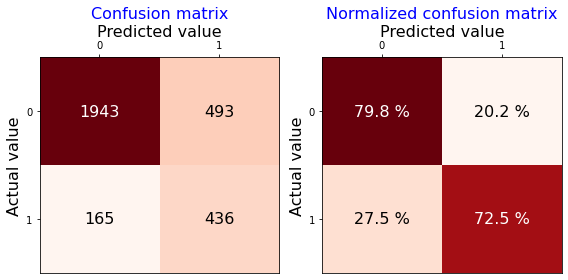

In [90]:
%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
lr = LogisticRegression(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(lr.threshold,[0.5])\
             .addGrid(lr.maxIter, [8])\
             .addGrid(lr.family, ["auto"])\
             .build()
)
log_cm_metrics, log_pred = BuildMLModel(lr, df_train_vec, df_test_vec, paramGrid)

In [91]:
# log_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Decision Tree Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [92]:
# %%time
# from pyspark.ml.classification import DecisionTreeClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(dt.maxDepth,[23,24,25,26,27])\
#              .addGrid(dt.maxDepth,[25])\
# #              .addGrid(dt.maxBins,[5,10,15])\
#              .addGrid(dt.maxBins,[15])\
# #              .addGrid(dt.impurity, ["entropy", "gini"])\
#              .addGrid(dt.impurity, ["gini"])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train_vec)

# # crossvalidateData.bestModel.getOrDefault("maxDepth")
# # crossvalidateData.bestModel.getOrDefault("maxBins")
# crossvalidateData.bestModel.getOrDefault("impurity")

In [93]:
# crossvalidateData.bestModel.extractParamMap()

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 396 ms, sys: 139 ms, total: 535 ms
Wall time: 24.5 s


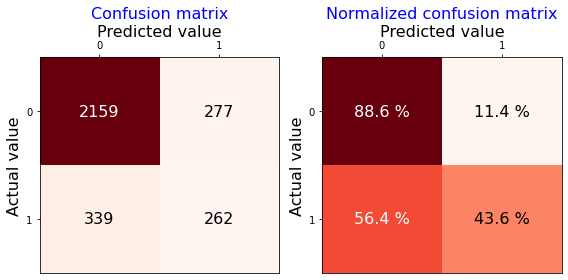

In [94]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(dt.maxDepth,[25])\
             .addGrid(dt.maxBins,[15])\
             .addGrid(dt.impurity, ["gini"])\
             .build()
)
dt_cm_metrics, dt_pred = BuildMLModel(dt, df_train_vec, df_test_vec, paramGrid)

In [95]:
# dt_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Random Forest Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

In [96]:
# %%time
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# rf = RandomForestClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(rf.maxDepth,[2,3,4,5])\
#              .addGrid(rf.maxDepth,[5])\
# #              .addGrid(rf.maxBins,[40,45,50,55])\
#              .addGrid(rf.maxBins,[45])\
# #              .addGrid(rf.impurity, ["entropy", "gini"])\
#              .addGrid(rf.impurity, ["gini"])\
# #              .addGrid(rf.numTrees, [50,60,70,80,90])\
#              .addGrid(rf.numTrees, [60])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train_vec)


# # crossvalidateData.bestModel.getOrDefault("maxDepth")
# # crossvalidateData.bestModel.getOrDefault("maxBins")
# # crossvalidateData.bestModel.getOrDefault("impurity")
# crossvalidateData.bestModel.getOrDefault("numTrees")

In [97]:
# crossvalidateData.bestModel.extractParamMap()

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 418 ms, sys: 123 ms, total: 541 ms
Wall time: 18.1 s


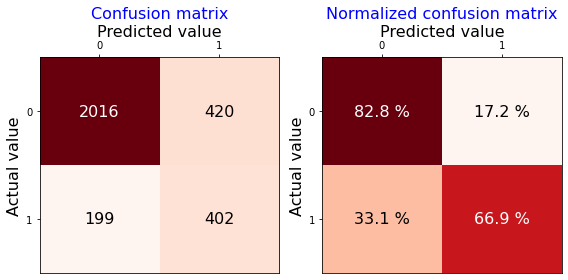

In [98]:
%%time
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(rf.maxDepth,[5])\
             .addGrid(rf.maxBins,[45])\
             .addGrid(rf.impurity, ["gini"])\
             .addGrid(rf.numTrees, [60])\
             .build()
)
rf_cm_metrics, rf_pred = BuildMLModel(rf, df_train_vec, df_test_vec, paramGrid)

In [99]:
# rf_cm_metrics

<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Get best parameters
</div>

In [100]:
# %%time

# from pyspark.ml.classification import NaiveBayes
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# nb = NaiveBayes(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(nb.modelType,["multinomial", "gaussian"])\
#              .addGrid(nb.modelType,["multinomial"])\
# #              .addGrid(nb.smoothing,[0.0, 0.002,0.004,0.006])\
#              .addGrid(nb.smoothing,[0.0])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
# crossvalidateData=crossvalidation.fit(df_train_vec)


# # crossvalidateData.bestModel.getOrDefault("modelType")
# crossvalidateData.bestModel.getOrDefault("smoothing")

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 360 ms, sys: 119 ms, total: 479 ms
Wall time: 10.7 s


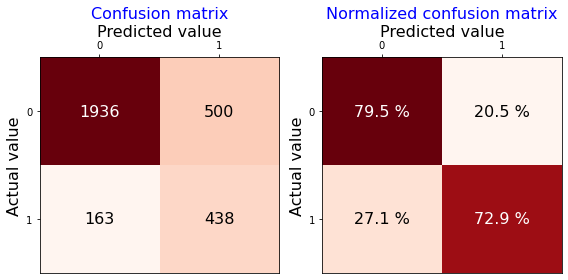

In [101]:
%%time
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
nb = NaiveBayes(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(nb.modelType,["multinomial"])\
             .addGrid(nb.smoothing,[0.0])\
             .build()
)
nb_cm_metrics, nb_pred = BuildMLModel(nb, df_train_vec, df_test_vec, paramGrid)

<div class="alert alert-block alert-success">
    <h4>
        Gradient-Boosted Tree Classification
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

In [102]:
# %%time
# from pyspark.ml.classification import GBTClassifier
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# gbt = GBTClassifier(labelCol="label", featuresCol="features")
# evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")\
# .setMetricName("accuracy") 

# paramGrid = (ParamGridBuilder()\
# #              .addGrid(gbt.featureSubsetStrategy, ["auto", "all", "sqrt", "onethird", "log2"])\
#              .addGrid(gbt.featureSubsetStrategy, ["auto"])\
# #              .addGrid(gbt.maxBins, [90,100,110])\
#              .addGrid(gbt.maxBins, [110])\
# #              .addGrid(gbt.maxDepth, [1,2,3,4])\
#              .addGrid(gbt.maxDepth, [4])\
# #              .addGrid(gbt.maxIter, [65,70,75,80])\
# #              .addGrid(gbt.maxIter, [80])\
# #              .addGrid(gbt.stepSize,[0.39, 0.392, 0.394, 0.396, 0.398, 0.399])\
# #              .addGrid(gbt.stepSize,[0.398])\
#              .build()
# )

# crossvalidation=CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)
# crossvalidateData=crossvalidation.fit(df_train_vec)



# # crossvalidateData.bestModel.getOrDefault("featureSubsetStrategy")
# # crossvalidateData.bestModel.getOrDefault("maxBins")
# # crossvalidateData.bestModel.getOrDefault("maxDepth")
# # crossvalidateData.bestModel.getOrDefault("maxIter")
# crossvalidateData.bestModel.getOrDefault("stepSize")

# # # best_params : featureSubsetStrategy="auto", maxBins=110, maxDepth=4, maxIter=65, stepSize=0.392,

In [103]:
# crossvalidateData.bestModel.extractParamMap()

<div class="alert alert-block alert-warning">
        Execute the model with the best parameters
</div>

CPU times: user 408 ms, sys: 117 ms, total: 525 ms
Wall time: 14.1 s


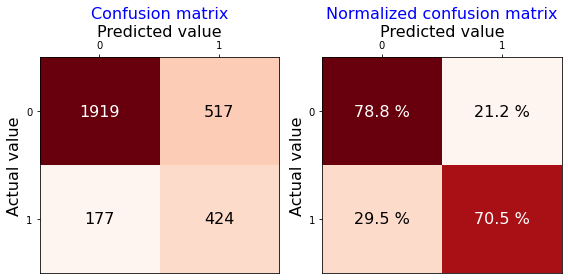

In [104]:
%%time
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
gbt = GBTClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()\
             .addGrid(gbt.featureSubsetStrategy, ["auto"])\
             .addGrid(gbt.maxBins, [110])\
             .addGrid(gbt.maxDepth, [4])\
             .addGrid(gbt.maxIter, [80])\
             .addGrid(gbt.stepSize,[0.398])\
             .build()
)
gbt_cm_metrics, gbt_pred = BuildMLModel(rf, df_train_vec, df_test_vec, paramGrid)

<a id='5.9'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [105]:
log_metrics = log_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
dt_metrics = dt_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
rf_metrics = rf_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
nb_metrics = nb_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
gbt_metrics = gbt_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
# lsv_metrics = lsv_cm_metrics.loc[:, ["Accuracy", "True Negative Rate", "True Positive Rate"]]
df_models = pd.concat([log_metrics, dt_metrics, rf_metrics, nb_metrics, gbt_metrics], axis=0)
df_models.index = ["log", "dt", "rf", "nb", "gbt"]
df_models = df_models.sort_values("Accuracy", ascending=False)
df_models

,Accuracy,True Negative Rate,True Positive Rate
dt,0.80,0.89,0.44
rf,0.80,0.83,0.67
log,0.78,0.80,0.73
nb,0.78,0.79,0.73
gbt,0.77,0.79,0.71


<a id='5.10'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Logistic Regression selected
</div>

In [106]:
model_pred = log_pred

In [107]:
model_pred = nb_pred

In [108]:
y_train_prob = np.array([i[0][1] for i in model_pred.select("probability").collect()])
y_train = np.array([i[0] for i in model_pred.select("label").collect()])

In [109]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_train_pred = (y_train_prob >= i/1000).astype('int')
    cm_train = confusion_matrix(y_train, y_train_pred)
    TN, FP, FN, TP = cm_train.ravel()
    
    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_train = roundF(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR_train = roundF(TN / (TN + FP), 2)
    # False positive rate or False alarm rate
    FPR_train = roundF(FP / (FP + TN), 2)
    # accuracy (ACC)
    acc_train = roundF((TP + TN) / (TP + TN + FP + FN), 2)
    # Precision or positive predictive value
    precision_train = roundF(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    npv_train = roundF(TN / (TN + FN), 2)    

    
#     df_cm_train_metrics = TP_FP_TN_FN_func(cm_train, 'Test')
#     TPR_train = df_cm_train_metrics.loc['True Positive Rate',0]
#     TNR_train = df_cm_train_metrics.loc['True Negative Rate',0]
#     FPR_train = df_cm_train_metrics.loc['False positive rate',0]
#     acc_train = df_cm_train_metrics.loc['Accuracy',0]
#     precision_train = df_cm_train_metrics.loc['Precision',0]
#     npv_train = df_cm_train_metrics.loc['Negative Predictive Value',0]
    
    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/1000)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 1.13 s, sys: 4.25 ms, total: 1.14 s
Wall time: 1.13 s


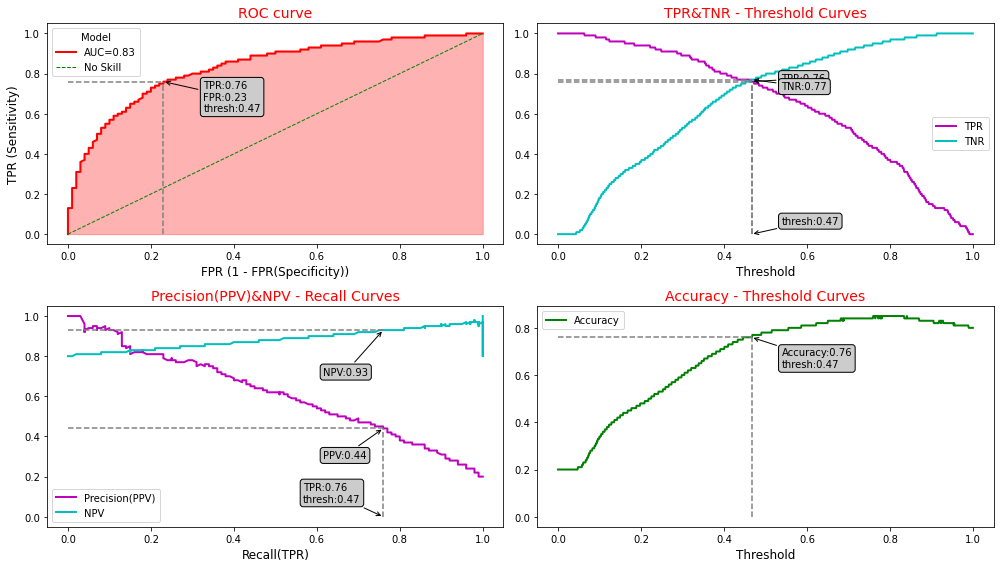

In [110]:
from sklearn.metrics import roc_auc_score

threshold=0.465
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_train, y_train_prob)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-warning">
        Final Confusion Matrix with new Threshold
</div>

In [111]:
y_train_pred = (y_train_prob  >= threshold).astype('int')
cm_final = confusion_matrix(y_train, y_train_pred)
cm_final_norm = confusion_matrix(y_train, y_train_pred, normalize='true')

,True Positive Rate,True Negative Rate,Accuracy,Balanced Accuracy,Precision,Negative Predictive Value,False Discovery Rate,False Omission Rate,Prevalence Threshold,F1 Score,Matthews Correlation Coefficient,False positive rate,False Negative Rate
,0.76,0.77,0.76,0.76,0.44,0.93,0.56,0.07,0.35,0.56,0.44,0.23,0.24


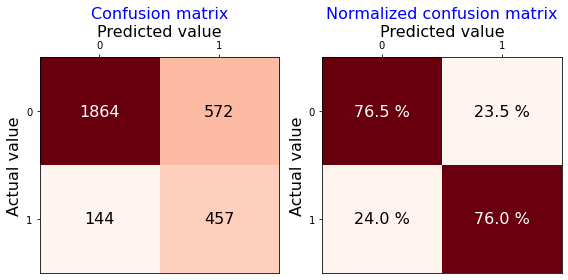

In [112]:
confusion_matrix_func(cm_final, cm_final_norm)

In [113]:
#Close spark session
spark.stop()